In [82]:
import numpy as np
import pandas as pd

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
from numpy.typing import NDArray
from tabulate import tabulate
from typing import List, Tuple, Union
from ucimlrepo import fetch_ucirepo

In [39]:
# Various configurations
plt.style.use("seaborn-v0_8-darkgrid")

In [40]:
# Various variables used in the code
random_state = 42

In [102]:
# Various utility functions for handling DataFrame features

def get_feature_names_by_type(df: pd.DataFrame, type: str) -> List[str]:
    """
    Get feature names of a specific type from a DataFrame.

    Parameters
    ----------

    df : pd.DataFrame
        DataFrame containing the features.

    type : str
        The type of features to filter by (e.g., 'int64', 'float64').

    Returns
    -------
    feature_names : List[str]
        List of feature names that match the specified type.

    """

    return [feature for feature in df.columns if df[feature].dtype == type]


def print_unique_values(df: pd.DataFrame, features: Union[str, List[str]]) -> None:
    """
    Print unique values for each passed feature in the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the features.

    features : Union[str, List[str]]
        Feature name or list of feature names to report unique values for.

    Returns
    -------
    None

    """

    if isinstance(features, str):
        features = [features]

    for feature in features:
        print(
            df[feature]
            .value_counts(dropna=False, normalize=True)
            .sort_index()
            .to_string()
        )
        print(f"Unique values: {df[feature].nunique()}\n")


def impute_random_probability_values(
    df: pd.DataFrame, features: Union[str, List[str]]
) -> pd.DataFrame:
    """
    Impute NaN values in specified feature(s) with random probability values
    based on existing values.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the features.

    features : Union[str, List[str]]
        Feature name or list of feature names to impute NaN values for.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with NaN values imputed in specified features.

    """

    if isinstance(features, str):
        features = [features]

    for feature in features:
        na_indices = df[feature][df[feature].isna()].index
        if len(na_indices) == 0:
            continue
        samples = (
            df[feature]
            .dropna()
            .sample(
                n=len(na_indices),
                replace=True,
                random_state=random_state,
            )
        )
        samples.index = na_indices
        df.loc[na_indices, feature] = samples

    return df


def lift_score(
    y_true: pd.Series, y_score: pd.Series, pos_label: Union[int, str] = 1
) -> float:
    """
    Calculate the lift score for a binary classifier.

    Parameters
    ----------
    y_true : array-like
        True binary labels (0/1 or False/True).
    y_score : array-like
        Predicted probabilities or scores for the positive class.
    pos_label : int or str, default=1
        The label of the positive class.

    Returns
    -------
    lift : float
        The lift score.
    """

    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)

    # Sort by predicted score descending
    order = np.argsort(y_score)[::-1]
    y_true_sorted = y_true[order]
    
    # Cumulative positives
    cumulative_positives = np.cumsum(y_true_sorted == pos_label)
    
    # Fraction of positives found in top N
    total_positives = np.sum(y_true == pos_label)
    if total_positives == 0:
        return 0.0
    
    # Fraction of sample
    fraction = np.arange(1, len(y_true) + 1) / len(y_true)
    
    # Fraction of positives found
    fraction_positives = cumulative_positives / total_positives
    
    # Lift at each point
    lift = fraction_positives / fraction
    
    # Return the maximum lift (usually at the top of the list)
    return np.max(lift)


def alift_curve(
    y_true: pd.Series, y_pred: pd.Series, pos_label: Union[int, str] = 1
) -> Tuple[
    NDArray[np.float32],
    NDArray[np.float32],
    NDArray[np.float32],
    NDArray[np.float32],
]:
    """
    Calculate the ALift curve for a binary classification problem.

    Parameters
    ----------
    y_true : pd.Series
        True labels of the data.

    y_pred : pd.Series
        Predicted labels of the data.

    pos_label : Union[int, str], optional
        The label considered as positive (default is 1).

    Returns
    -------
    alift_df : pd.DataFrame
        DataFrame containing the ALift curve data.

    """

    false_positive_rates, true_positive_rates, thresholds = roc_curve(
        y_true,
        y_pred,
        pos_label=pos_label,
    )
    alift = true_positive_rates - false_positive_rates

    return (
        false_positive_rates,
        true_positive_rates,
        thresholds,
        alift,
    )

def alift_curve_2(y_true: pd.Series, probabilities: pd.Series) -> NDArray[np.float32]:
    # Sort true labels by predicted probabilities in descending order
    sorted_indices = np.argsort(probabilities)[::-1]
    y_true = y_true.to_numpy()
    y_sorted = y_true[sorted_indices]
    model_cumulative = np.cumsum(y_sorted)

    return model_cumulative

In [42]:
# Fetch dataset from UCI Machine Learning Repository
bank_marketing_dataset = fetch_ucirepo(id=222)

In [43]:
# Display feature information
print(bank_marketing_dataset.metadata.additional_info.variable_info)

Input variables:
   # bank client data:
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   5 - default: has credit in default? (binary: "yes","no")
   6 - balance: average yearly balance, in euros (numeric) 
   7 - housing: has housing loan? (binary: "yes","no")
   8 - loan: has personal loan? (binary: "yes","no")
   # related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  10 - day: last contact day of the month (numeric)
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "no

In [44]:
categorical_features = [
    "contact",
    "day_of_month",
    "education",
    "job",
    "marital",
    "month",
    "poutcome",
]
numerical_features = [
    "age",
    "balance",
    "campaign",
    "pdays",
    "previous",
]
binary_features = [
    "default",
    "housing",
    "loan",
    "y",
]

In [45]:
# Access the original DataFrame
df = bank_marketing_dataset.data.original

In [46]:
# Rename `day_of_week` to `day_of_month` for clarity
if 'day_of_week' in df.columns:
    df = df.rename(columns={"day_of_week": "day_of_month"})

In [47]:
# Display first few rows of dataset
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_month,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [48]:
# Display shape of dataset
df.shape

(45211, 17)

In [49]:
# Display statistics of continuous variables
df.describe()

,age,balance,day_of_month,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [56]:
# Display type information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           45211 non-null  int64 
 1   job           45211 non-null  object
 2   marital       45211 non-null  object
 3   education     45211 non-null  object
 4   default       45211 non-null  int64 
 5   balance       45211 non-null  int64 
 6   housing       45211 non-null  int64 
 7   loan          45211 non-null  int64 
 8   contact       45211 non-null  object
 9   day_of_month  45211 non-null  object
 10  month         45211 non-null  object
 11  campaign      45211 non-null  int64 
 12  pdays         45211 non-null  int64 
 13  previous      45211 non-null  int64 
 14  poutcome      45211 non-null  object
 15  y             45211 non-null  int64 
dtypes: int64(9), object(7)
memory usage: 5.5+ MB


In [50]:
# Check for any NaN values
df.isna().any()

age             False
job              True
marital         False
education        True
default         False
balance         False
housing         False
loan            False
contact          True
day_of_month    False
month           False
duration        False
campaign        False
pdays           False
previous        False
poutcome         True
y               False
dtype: bool

In [51]:
# Remove the 'duration' feature because it represents the duration of the last
# call, which is not known before making a prediction and thus cannot be used
# for predictive modeling.
if 'duration' in df.columns:
    df = df.drop(columns=['duration'], axis=1)

In [58]:
# Impute NaN values in categorical features with string 'unknown'
for feature in categorical_features:
    if df[feature].isna().any():
        df[feature] = df[feature].fillna('unknown')

print_unique_values(df, categorical_features)

contact
cellular     0.647741
telephone    0.064276
unknown      0.287983
Unique values: 3

day_of_month
1     0.007122
10    0.011590
11    0.032713
12    0.035456
13    0.035058
14    0.040875
15    0.037668
16    0.031298
17    0.042888
18    0.051050
19    0.038862
2     0.028599
20    0.060870
21    0.044812
22    0.020017
23    0.020769
24    0.009887
25    0.018580
26    0.022893
27    0.024795
28    0.040477
29    0.038597
3     0.023866
30    0.034638
31    0.014222
4     0.031961
5     0.042246
6     0.042733
7     0.040189
8     0.040742
9     0.034527
Unique values: 31

education
primary      0.151534
secondary    0.513194
tertiary     0.294198
unknown      0.041074
Unique values: 4

job
admin.           0.114375
blue-collar      0.215257
entrepreneur     0.032890
housemaid        0.027427
management       0.209197
retired          0.050076
self-employed    0.034925
services         0.091880
student          0.020747
technician       0.168034
unemployed       0.028820
unkno

In [53]:
# Transform yes/no to 0/1 in binary features
for feature in binary_features:
    if df[feature].dtype == "object":
        df[feature] = (df[feature] == "yes").astype(int)

print_unique_values(df, binary_features)

default
0    0.981973
1    0.018027
Unique values: 2

housing
0    0.444162
1    0.555838
Unique values: 2

loan
0    0.839774
1    0.160226
Unique values: 2

y
0    0.883015
1    0.116985
Unique values: 2



In [67]:
# Due to a mix of categorical and ordinal values within the `pdays` feature, we
# need to split the dataset into two parts: prospect and client. This split will
# serve two different models, as the prospect model will focus on potential
# clients who have not yet been contacted, while the client model will target
# those who have already been reached out to.
prospect_df = df[df["pdays"] == -1].copy()
prospect_df = prospect_df.drop(columns=["pdays", "poutcome"], axis=1) # pdays is -1 and poutcome is irrelevant for prospects

client_df = df[df["pdays"] != -1].copy()

In [77]:
# Define X and y for modeling
X = client_df.drop(columns=["y"], axis=1)
y = client_df["y"]

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (8257, 15), y shape: (8257,)


In [78]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=random_state,
    stratify=y, # Ensure the split maintains the same proportion of classes
    test_size=0.25, # 25% of the data for testing
)

In [79]:
# Define list of classifiers to be used in modeling process
models = [
    ["Neural Net", MLPClassifier(alpha=1, max_iter=1000, random_state=random_state)],
    ["Random Forest", RandomForestClassifier(random_state=random_state)],
    ["AdaBoost", AdaBoostClassifier(random_state=random_state, learning_rate=0.1)],
]

In [103]:
# Define dictionary to store results of each classifier
results = {}

print("Start modelling:")

# Loop through each classifier, fit, cross-validate and store results
for name, model in models:
    print(f"- {name}")

    pipeline = make_pipeline(
        ColumnTransformer(
            [
                (
                    "categorical",
                    OneHotEncoder(sparse_output=False),
                    get_feature_names_by_type(X_train, "object"),
                ),
            ],
            remainder=StandardScaler(),
        ),
        SMOTE(
            random_state=random_state,
            sampling_strategy="minority",
        ),
        model,
    )

    folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    auc_scores = []
    alift_scores = []
    auc_curves = []
    alift_curves = []

    for fold_train_indices, fold_test_indices in folds.split(X_train, y_train):
        X_fold_train, X_fold_test = (
            X_train.iloc[fold_train_indices],
            X_train.iloc[fold_test_indices],
        )
        y_fold_train, y_fold_test = (
            y_train.iloc[fold_train_indices],
            y_train.iloc[fold_test_indices],
        )

        pipeline.fit(X_fold_train, y_fold_train)
        y_fold_probabilities = pipeline.predict_proba(X_fold_test)[:, 1]
        y_fold_predictions = (y_fold_probabilities >= 0.5).astype(int)

        auc_scores.append(roc_auc_score(y_fold_test, y_fold_probabilities))
        auc_curves.append(roc_curve(y_fold_test, y_fold_probabilities))
        alift_scores.append(lift_score(y_fold_test, y_fold_probabilities))
        alift_curves.append(alift_curve(y_fold_test, y_fold_predictions))

    # Use mean scores and the first curve for plotting
    results[name] = {
        "AUC": [
            np.mean(auc_scores),
            auc_curves[0],
        ],
        "ALIFT": [
            np.mean(alift_scores),
            alift_curves[0],
        ],
    }

print("✅ Modelling completed.")

Start modelling:
- Neural Net
- Random Forest
- AdaBoost
✅ Modelling completed.


In [104]:
# Display AUC and ALift scores
headers = ["Metric"] + list(results.keys())
metrics = list(results[list(results.keys())[0]].keys())
table = [
    [metric] + [f"{result[metric][0]:.4f}" for result in results.values()]
    for metric in metrics
]

print(tabulate(table, headers, tablefmt="github"))

| Metric   |   Neural Net |   Random Forest |   AdaBoost |
|----------|--------------|-----------------|------------|
| AUC      |       0.8341 |          0.8353 |     0.8025 |
| ALIFT    |       4.3331 |          4.3331 |     4.044  |


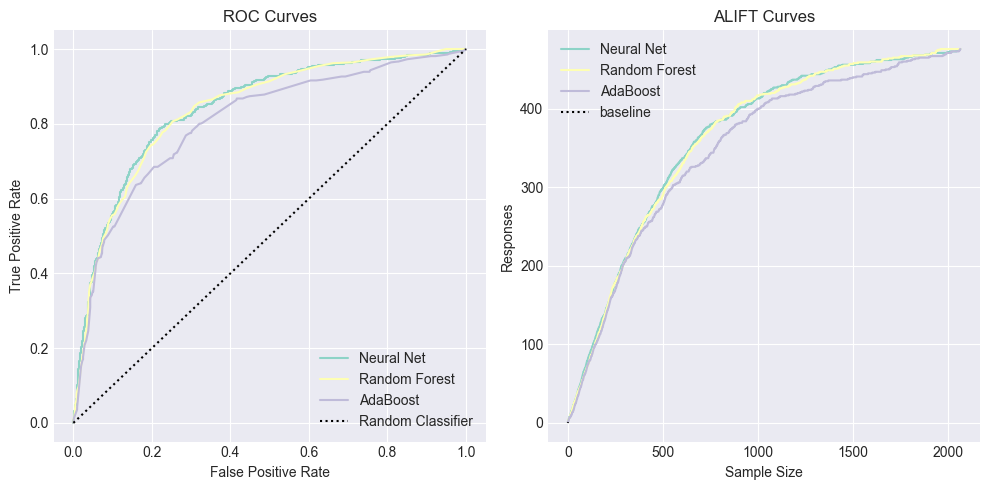

In [ ]:
fig, (auc_plot, alift_plot) = plt.subplots(1, 2, figsize=(10, 5))

for name in results:
    responses, true_positive_rates, thresholds = results[name]["AUC"][1]
    auc_plot.plot(
        responses,
        true_positive_rates,
        label=name,
    )
auc_plot.plot([0, 1], [0, 1], "k:", label="Random Classifier")
auc_plot.set_title("ROC Curves")
auc_plot.set_xlabel("False Positive Rate")
auc_plot.set_ylabel("True Positive Rate")
auc_plot.legend()

for name in results:
    responses = results[name]["ALIFT"][1]
    alift_plot.plot(
        responses,
        # true_positive_rates,
        label=name,
    )
alift_plot.plot([0, 1], [0, 1], "k:", label="baseline")
alift_plot.set_title("ALIFT Curves")
alift_plot.set_xlabel("Sample Size")
alift_plot.set_ylabel("Responses")
alift_plot.legend()

plt.tight_layout()
plt.show()
